In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

#Cross validation
from sklearn.model_selection import cross_val_score

In [2]:
#load data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

In [4]:
#Minimum exploratory data analysis (mostly is already explored on excellent blog entries about the competition)

In [5]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [6]:
# preview the data
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [8]:
test_df.loc[test_df["Fare"]<0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [9]:
corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

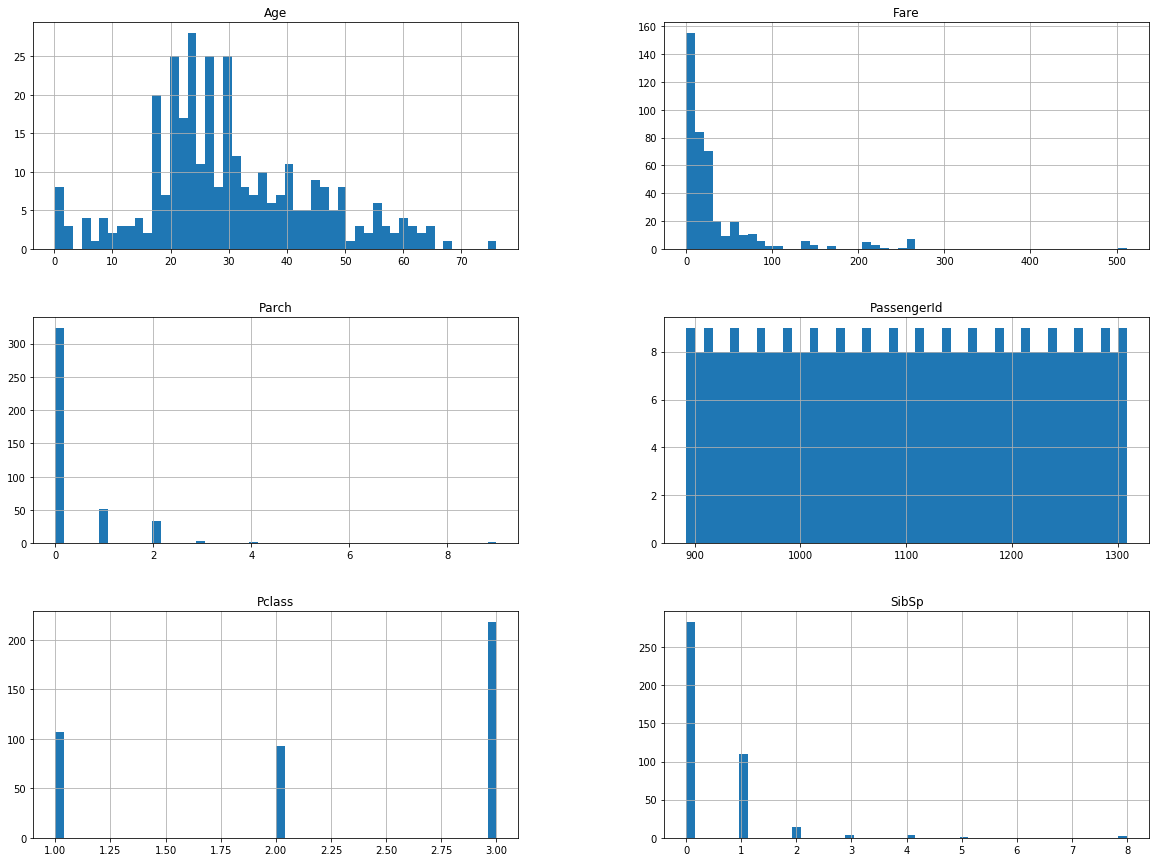

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
test_df.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
#Feature Torturing
#
#
#

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [13]:
# fill missing embarkation port
from sklearn.base import TransformerMixin

class FillPort(TransformerMixin):
    def fit(self, X, y=None):
        self.most_common_port=X.Embarked.dropna().mode()[0]
        return self
    def transform(self, X):
        X["Embarked"].fillna(self.most_common_port,inplace=True)
        return X



In [14]:
# fill missing fare - only one in the train set... 
# Besides there are 15 fares set to 0 in the training set

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

class FillFare(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.model = LinearRegression()
        #self.model = RandomForestRegressor() 
        self.model = KNeighborsRegressor(n_neighbors=1) 
    def fit(self, X, y=None):
        self.X_withfare=X.loc[X["Fare"]>0]
        y=self.X_withfare["Fare"]
        X_clear=self.X_withfare.drop("Fare", axis=1).drop("Age", axis=1)
        if "Survived" in X_clear.columns:
            X_clear=X_clear.drop("Survived", axis=1)
        self.model.fit(X_clear, y)
        return self
    def transform(self, X):
        X_to_replace=X.drop("Fare", axis=1).drop("Age", axis=1)
        X_to_replace_clear=X_to_replace
        if "Survived" in X_to_replace_clear.columns:
            X_to_replace_clear=X_to_replace_clear.drop("Survived", axis=1)
        y_to_replace=pd.DataFrame(self.model.predict(X_to_replace_clear))
        y_to_replace.columns=["Fare"]
        X_to_replace["Fare"]=X[:]["Fare"].fillna(y_to_replace[:]["Fare"]) #is there a way to write this clearly?
        X_to_replace["Age"]=X[:]["Age"]
        return X_to_replace



In [15]:
# Tranform fare to look more gaussian
from sklearn.base import TransformerMixin

class ChangeFare(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X["Fare"]=np.log(X["Fare"]+0.001)
        return X

In [16]:
# change Pclass
from sklearn.base import TransformerMixin

class ChangePclass(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tag=pd.get_dummies(X["Pclass"],prefix="Pclass")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Pclass", axis=1)


In [17]:
# change embarked
from sklearn.base import TransformerMixin

class ChangeEmbarked(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tag=pd.get_dummies(X["Embarked"],prefix="Embarked")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Embarked", axis=1)
        



In [18]:
# change sex from string to numeric
from sklearn.base import TransformerMixin

class ChangeSex(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.iloc[:]["Sex"]=X.iloc[:]["Sex"].map({"male":1,"female":0})
        return X

In [19]:
# change name
from sklearn.base import TransformerMixin

class ChangeName(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Title"]=X["Name"].map(lambda name:name.split(',')[1].split('.')[0].strip())
        Title_Dictionary = {
            "Capt":       "Crew",
            "Col":        "Crew",
            "Major":      "Crew",
            "Jonkheer":   "Rare",
            "Don":        "Rare",
            "Sir" :       "Rare",
            "Dr":         "Crew",
            "Rev":        "Crew",
            "the Countess":"Rare",
            "Dona":       "Rare",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Rare"
        }
        X["Title"]=X.Title.map(Title_Dictionary)
        tag=pd.get_dummies(X["Title"],prefix="Title")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Name", axis=1).drop("Title", axis=1)
        
    


In [20]:
# change ticket
from sklearn.base import TransformerMixin

class ChangeTicket(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):

        # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
        def cleanTicket(ticket):
            ticket = ticket.replace('.','')
            ticket = ticket.replace('/','')
            ticket = ticket.split()
            ticket = list(ticket)
            ticket = map(lambda t : t.strip() , ticket)
            ticket = list(ticket)
            ticket = filter(lambda t : not t.isdigit(), ticket)
            ticket = list(ticket)
            if len(ticket) > 0:
                return ticket[0]
            else: 
                return 'XXX'
        
        X["Ticket"]=X["Ticket"].map(cleanTicket)
        tag=pd.get_dummies(X["Ticket"],prefix="Ticket")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Ticket",axis=1)
        

    

In [21]:
# change cabin
from sklearn.base import TransformerMixin

class ChangeCabin(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Cabin"].fillna("U", inplace=True)
        X["Cabin"]=X["Cabin"].map(lambda c : c[0])
        tag=pd.get_dummies(X["Cabin"], prefix="Cabin")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Cabin", axis=1)
        




In [22]:
# create family parameters
from sklearn.base import TransformerMixin

class CreateFamily(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["FamilySize"]=X["SibSp"]+X["Parch"]+1
        X["Alone"]=X["FamilySize"].map(lambda s : 1 if s == 1 else 0)
        X["NormalFamily"]=X["FamilySize"].map(lambda s : 1 if 2<=s<=4 else 0)
        X["LargeFamily"]=X["FamilySize"].map(lambda s : 1 if 5<=s else 0)
        return X
 

In [23]:
# fill missing Age with Regressor (must be last - regressor needs numeric attribs)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

class ChangeAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.model = LinearRegression()
        #self.model = RandomForestRegressor() 
        self.model = KNeighborsRegressor(n_neighbors=1) 
    def fit(self, X, y=None):
        self.X_withage=X.loc[X["Age"].notnull()]
        y=self.X_withage["Age"]
        X_clear=self.X_withage.drop("Age", axis=1)
        if "Survived" in X_clear.columns:
            X_clear=X_clear.drop("Survived", axis=1)
        self.model.fit(X_clear, y)
        #acc=(cross_val_score(self.model, X_clear, y, cv=5, scoring="accuracy").mean()) * 100
        #print(acc)
        return self
    def transform(self, X):
        X_to_replace=X.drop("Age", axis=1)
        X_to_replace_clear=X_to_replace
        if "Survived" in X_to_replace_clear.columns:
            X_to_replace_clear=X_to_replace_clear.drop("Survived", axis=1)
        y_to_replace=pd.DataFrame(self.model.predict(X_to_replace_clear))
        y_to_replace.columns=["Age"]
        X_to_replace["Age"]=X[:]["Age"].fillna(y_to_replace[:]["Age"]) #is there a way to write this clearly?
        return X_to_replace
        

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [25]:
feature_engineering_pipeline = Pipeline([
    ('fill_port', FillPort()),
    ('change_embarked', ChangeEmbarked()),
    ('change_pclass', ChangePclass()),
    ('change_sex', ChangeSex()),
    ('change_name', ChangeName()),
    ('change_ticket', ChangeTicket()),
    ('change_cabin', ChangeCabin()),
    ('create_family', CreateFamily()),
    ('change_fare', ChangeFare()),
    ('fill_fare', FillFare()),
    ('change_age', ChangeAge()),
])



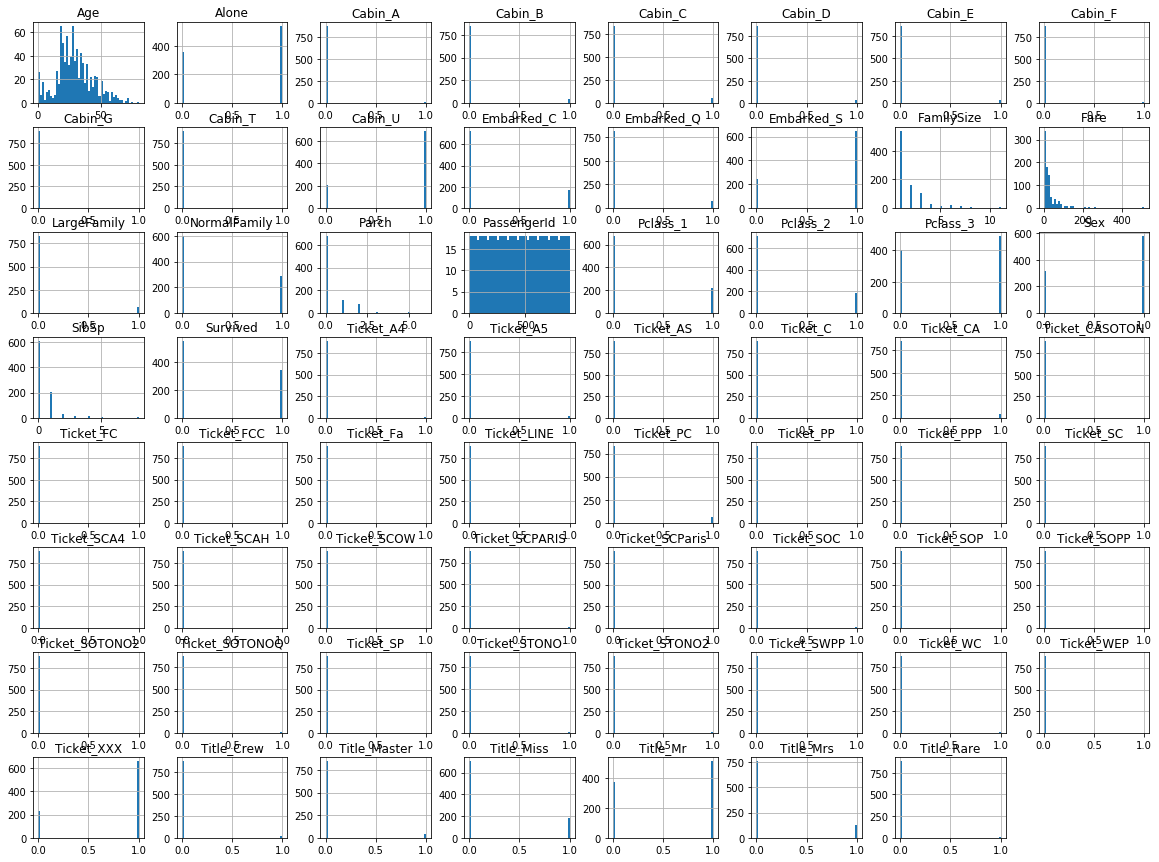

In [26]:
train_df_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(train_df))
test_df_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(test_df))

train_df_tr.hist(bins=50, figsize=(20,15))
plt.show()
#train_df.describe(),test_df.describe()


In [27]:
#let's find anomalies

from sklearn.decomposition import KernelPCA

pca = KernelPCA(kernel='rbf', n_components=3)  # Reduce to k=3 dimensions


In [28]:
X_reduce = pca.fit_transform(train_df_tr)

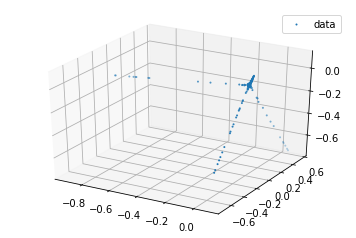

In [29]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], 
           zs=X_reduce[:, 2], 
           s=4, lw=0, label="data")
ax.legend()

In [30]:
# Feature selection




In [31]:
# Create a combined dataset (train + test) to check features
combined=pd.concat([train_df.drop("Survived",axis=1), test_df], axis=0)
combined_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(combined))
#combined.describe()

In [32]:
X_train = combined_tr[0:891]
X_test = combined_tr[891:]
Y_train = train_df_tr["Survived"]



In [33]:
#hack
test_df_y = pd.read_csv('test_y.csv')
Y_test=test_df_y["Survived"]


In [34]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((891, 68), (891,), (418, 68), (418,))

In [35]:
#feature scaling

from sklearn.preprocessing import StandardScaler, RobustScaler

scaler=StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
Y_train_scaled = np.array((Y_train))
Y_test_scaled = np.array((Y_test))


In [36]:
#X_combined_scaled=np.append(X_train_scaled,X_test_scaled,axis=0)
#Y_combined_scaled=np.append(Y_train_scaled,Y_test_scaled, axis=0)
#X_combined_scaled.shape, Y_combined_scaled.shape

In [37]:
from sklearn.ensemble import IsolationForest

out_clf=IsolationForest(n_estimators=1000, max_features=0.5, contamination=0.01)
%time out_clf.fit(X_train_scaled)
outliers=out_clf.predict(X_train_scaled)


#for i in range (0, len(X_train_scaled)):
#        if outliers[i]==-1:
#            print(train_df[i])
#            X_train_scaled = np.delete(X_train_scaled, (i), axis=0)
#            Y_train_scaled = np.delete(Y_train_scaled, (i), axis=0)
            


Wall time: 1.74 s


In [38]:
(train_df.loc[outliers[:]<1]).sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
835,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S


In [39]:
# limit tensorflow GPU memory usage

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [40]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import ELU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import SGD


In [41]:
def model_func():
    # create model
    #
    model = Sequential()
    model.add(Dense(30, kernel_initializer='he_normal', bias_initializer='he_normal',input_dim=68))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(30, kernel_initializer='he_normal', bias_initializer='he_normal'))
    model.add(ELU())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.9, nesterov=True),
                #optimizer='Nadam',  
                metrics=['accuracy','binary_accuracy'])
    return model

In [42]:
from keras.callbacks import TensorBoard
from time import time

tensorboard=TensorBoard(log_dir="logs/{}".format(time()))

In [43]:
from keras.wrappers.scikit_learn import KerasClassifier

    
model = KerasClassifier(build_fn=model_func, callbacks=[tensorboard], epochs=10000, batch_size=200, verbose=0)
model=model_func()


In [44]:
# from sklearn.ensemble import BaggingClassifier
# from keras.wrappers.scikit_learn import KerasClassifier

#bag_clf = BaggingClassifier(base_estimator=KerasClassifier(build_fn=model_func, epochs=100, batch_size=200, verbose=0), n_estimators=20, n_jobs=1,max_samples=0.2, max_features=1.0, oob_score=True)
#%time temp=bag_clf.fit(X_train_scaled,Y_train_scaled)

validation_split=0.2,
%time temp=model.fit (X_train_scaled, Y_train_scaled, validation_data=(X_test_scaled,Y_test_scaled), callbacks=[tensorboard], epochs=10000, batch_size=200, verbose=0)

Wall time: 7min 9s


In [45]:
# %time acc_nn = (cross_val_score(temp, X_train_scaled, Y_train_scaled, cv=5).mean()) * 100
# acc_nn

In [50]:
%time Y_pred=model.predict(X_test_scaled)
#Y_pred

Wall time: 49.1 ms


In [47]:
# %time acc_nn = model.score(X_train_scaled,Y_train_scaled)
# print(np.mean(acc_nn)*100)

In [48]:
# bag_clf.oob_score_

In [51]:
from sklearn.metrics import accuracy_score

acc_nn = accuracy_score(Y_test_scaled.astype(int), Y_pred)
print(np.mean(acc_nn)*100)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [52]:
# Keras scores
scores = model.evaluate(X_test_scaled,Y_test_scaled,verbose=0)
scores

[nan, 0.72009569377990434, 0.72009569377990434]

In [ ]:
# Submission

# He didn't confess yet, but he will...



In [ ]:
(Y_pred[:,0]).shape

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df_tr["PassengerId"],
        #"Survived": (Y_pred[:,0])
        "Survived": (Y_pred)
    })
submission.to_csv('submission.csv', index=False)

In [ ]:
# Use Extra Trees to find feature importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

parameter_grid_selection = {
    'max_depth' : [4, 6, 8],
    'n_estimators': [10, 50,100,200],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [True, False],
}

clf = ExtraTreesClassifier(n_estimators=200)
#grid_selection=GridSearchCV(estimator=clf, param_grid=parameter_grid_selection, cv=5, scoring="accuracy")
#%time grid_selection = grid_selection.fit(X_train, Y_train)
# Selected parameters are in the commented line in the next cell
#print('Best score: {}'.format(grid_selection.best_score_))
#print('Best parameters: {}'.format(grid_selection.best_params_))


In [ ]:
#clf = ExtraTreesClassifier(bootstrap=False, max_depth=8, min_samples_leaf=3, min_samples_split=2, n_estimators=50)

clf.fit(X_train, Y_train)

features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(['importance'],ascending=False)


In [ ]:
model = SelectFromModel(clf, prefit=True)
X_train_selected = model.transform(X_train)
X_train_selected.shape

In [ ]:
X_test_selected = model.transform(X_test)
X_test_selected.shape